# Imports

In [1]:
import numpy as np
from scipy import stats
import random

import matplotlib.pyplot as plt
%matplotlib inline

# import library
%run lib.ipynb

## Generate data (yulesimon)

In [2]:
from scipy.stats import yulesimon

def sample_yulesimon(alpha, size):
    return yulesimon.rvs(alpha, loc=0, size=size)

def next_alpha(min_alpha=2.0, max_alpha=3.0):
    alpha = np.random.uniform(low=min_alpha, high=max_alpha, size=1)[0]
    return alpha

# generate data
H, y = generate_data(N=10000, M=256, nextConfig=next_alpha, sample=sample_yulesimon)

# log scale histogram rows
# replace zero values of H with one (so as not to take log of zero)
H_copy = H.copy()
H_copy[H_copy == 0] = 1
log_H = np.apply_along_axis(lambda a: np.log10(a), 1, H_copy)

# cumsum
cumsum_log_H = np.apply_along_axis(lambda a: np.cumsum(a[::-1])[::-1], 1, log_H)

# X is the input for the learning process
X = log_H
#X = cumsum_log_H

### Plot histogram and log scale of a single row

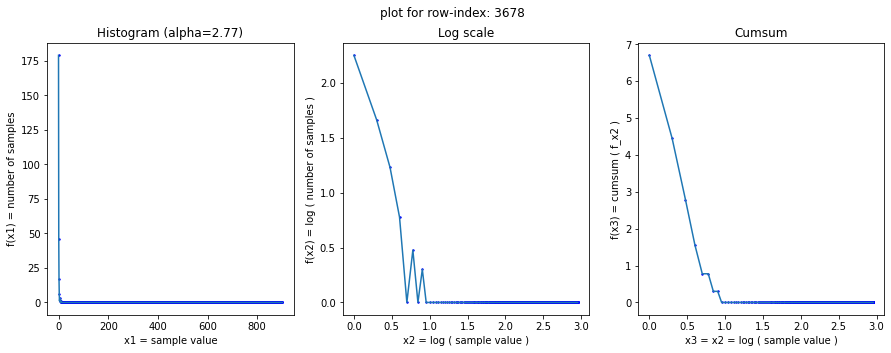

In [3]:
# plot random row
ROW_INDEX_TO_PLOT = random.randint(0, H.shape[0])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle(f'plot for row-index: {ROW_INDEX_TO_PLOT}')

# plot histogram
f_x1 = H[ROW_INDEX_TO_PLOT,:]
x1 = np.array(range(len(f_x1)))
plt.subplot(1, 3, 1)
plt.title('Histogram (alpha={:.2f})'.format(y[0]))
plt.xlabel('x1 = sample value')
plt.ylabel('f(x1) = number of samples')
_ = plt.plot(x1, f_x1, zorder=2)
_ = plt.scatter(x1, f_x1, zorder=1, s=2, color="blue")

# plot log scale
x2 = np.log10(x1+1)
f_x2 = log_H[ROW_INDEX_TO_PLOT,:]
plt.subplot(1, 3, 2)
plt.title('Log scale')
plt.xlabel('x2 = log ( sample value )')
plt.ylabel('f(x2) = log ( number of samples )')
_ = plt.plot(x2, f_x2, zorder=2)
_ = plt.scatter(x2, f_x2, zorder=1, s=2, color="blue")

# plot cumsum
x3 = x2
f_x3 = np.cumsum(f_x2[::-1])[::-1]
plt.subplot(1, 3, 3)
plt.title('Cumsum')
plt.xlabel('x3 = x2 = log ( sample value )')
plt.ylabel('f(x3) = cumsum ( f_x2 )')
_ = plt.plot(x3, f_x3, zorder=2)
_ = plt.scatter(x3, f_x3, zorder=1, s=2, color="blue")


# Split Train/Test

In [4]:
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(f'X_train.shape: {X_train.shape}')

X_train.shape: (7500, 902)


# Create and train DNN model

In [ ]:
dnn_model = create_dnn_model(X_train.shape[1], 
                        layers=[256,256], 
                        activation='relu', 
                        init=keras.initializers.HeUniform(), 
                        batch_normalization=True, 
                        dropout=0.0, 
                        optimizer=Adam(learning_rate=1e-2), 
                        k_reg=True,
                        k_reg_lr=1e-5, 
                        a_reg=True,
                        a_reg_lr=1e-5)

# train
dnn_model, history = train_model(dnn_model, X_train, y_train)

# plot learning curves
plot_learning_curves(history)

# predict
y_pred = dnn_model.predict(X_test).flatten()

# mse
mse = mean_squared_error(y_test, y_pred)

# sqrt_mse
sqrt_mse = np.sqrt(mse)

print(f'sqrt_mse: {sqrt_mse}')

# Create and train CNN model

In [ ]:
# # create cnn model
# X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# cnn_model = create_cnn_model(X_train_cnn.shape[1], filters=32)

# # train cnn model
# cnn_model, cnn_history = train_model(cnn_model, X_train_cnn, y_train)

# # plot learning curves
# plot_learning_curves(cnn_history)

# # predict
# X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# y_pred_cnn = cnn_model.predict(X_test_cnn).flatten()

# # mse
# mse_cnn = mean_squared_error(y_test, y_pred_cnn)

# # sqrt_mse
# sqrt_mse_cnn = np.sqrt(mse_cnn)

# print(f'sqrt_mse: {sqrt_mse_cnn}')